In [1]:
from PIL import Image
import numpy as np
from skimage import transform
import os
from skimage.transform import rotate
from scipy import ndimage
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
%matplotlib notebook

from NeuNorm.normalization import Normalization

import numpy as np
from skimage import feature

In [2]:
class BaseAlgorithm:
    
    def __init__(self, image1, image2):
        self.image_0_degree = image1
        self.image_180_degree = image2
    

In [3]:
class UseCenter(BaseAlgorithm):

    def compute(self, **kwds):

        centers = np.array(
                    [item for item
                     in self.iteration_centers(self.image_0_degree, self.image_180_degree, **kwds)])

        rows, centers = centers.T
        cm = np.median(centers)
        csigma = np.std(centers)
        w = (centers > cm - 1.5 * csigma) * (centers < cm + 1.5 * csigma)
        rows1 = rows[w]
        centers1 = centers[w]
        from scipy import stats
        try:
            tilt, intercept, r, p, std_err = stats.linregress(rows1, centers1)
        except ValueError:
            return np.NaN

        return tilt

    def iteration_centers(self, img0, img180, sigma=3, maxshift=20):
        edge0 = self.getEdge(img0, sigma=sigma)
        edge180 = self.getEdge(img180, sigma=sigma)
        edge180 = edge180[:, ::-1]
        for i, (line0, line180) in enumerate(zip(edge0, edge180)):
            c = self.compute_center_of_rotation(line0, line180, maxshift=maxshift)
            # print i,c
            if c > (line0.size - maxshift) / 2. + maxshift // 40.:  # remove edge cases
                yield i, c
            continue
        return

    def getEdge(self, img, **kwds):
        edge = feature.canny(img, **kwds)
        edge = np.array(edge, dtype="float32")
        return edge

    def compute_center_of_rotation(self, x1, x2, **kwds):
        shift = UseCenter.compute_shift(x1, x2, **kwds)
        return (shift + x1.size) / 2.

    @staticmethod
    def compute_shift(x1, x2, maxshift=20):
        """compute shift between two spectra
        when x1 is shifted by the result pixels, x1 is most similar to x2
        """
        diffs = []
        for dx in range(1 - maxshift, maxshift):
            if dx > 0:
                diff = x1[dx:] * x2[:-dx]
            elif dx < 0:
                diff = x1[:dx] * x2[-dx:]
            else:
                diff = x1 * x2
            diff = np.sum(diff * diff)
            diffs.append((dx, diff))
        diffs = np.array(diffs)
        # np.save("diffs.npy", diffs)
        X, Y = diffs.T
        w = np.argmax(Y)
        return X[w]


In [4]:
MAX_SHIFT = 400

class DirectMinimization(BaseAlgorithm):

    def compute(self):
        flipped_img180 = np.fliplr(self.image_180_degree)
        shift = self.find_shift(self.image_0_degree, flipped_img180)
        tilts = np.arange(-2., 2.1, 0.2)
        tilt = self.argmin_tilt(tilts, self.image_0_degree, flipped_img180, shift)
        tilts = np.arange(tilt - 0.2, tilt + 0.21, 0.02)
        tilt = self.argmin_tilt(tilts, self.image_0_degree, flipped_img180, shift)

        return tilt

    def shift_diff(self, x, img1, img2):
        # shift positive means img2 was shifted to the left,
        # or img1 was shifted to the right.
        x = int(x)
        if x > 0:
            left = img1[:, :-x]
            right = img2[:, x:]
        elif x < 0:
            left = img1[:, -x:]
            right = img2[:, :x]
        else:
            left = img1
            right = img2
        return left - right

    def shift_diff2(self, x, img1, img2):
        d = self.shift_diff(x, img1, img2)
        return (d ** 2).sum() / d.size

    def find_shift(self, img0, flipped_img180):
        """find the shift in number of pixels

        note: the relation between rot center and shift is
          rot_center = -shift/2 if 0 is center of image
        """
        # print("* Calculating shift...")
        ncols = img0.shape[1]

        def shift_diff2(x, img1, img2):
            d = self.shift_diff(x, img1, img2)
            return (d ** 2).sum() / d.size

        def diff(x):
            return shift_diff2(x, img0, flipped_img180)

        start = max(-ncols // 2, - MAX_SHIFT)
        end = min(MAX_SHIFT, ncols // 2)
        xs = range(start, end)
        diffs = [diff(x) for x in xs]
        index = np.argmin(diffs)
        guess = xs[index]
        return guess

    def argmin_tilt(self, tilts, img0, flipped_img180, shift):
        diffs = []
        for tilt in tilts:
            diff = self.shift_tilt_diff(shift, tilt, img0, flipped_img180)
            diff = np.sum(diff ** 2) / diff.size
            diffs.append(diff)
            continue
        return tilts[np.argmin(diffs)]

    def shift_tilt_diff(self, shift, tilt, img1, img2):
        nrows, ncols = img1.shape
        borderY, borderX = nrows // 20, ncols // 20
        a = rotate(img1 / np.max(img1), -tilt)[borderY:-borderY, borderX:-borderX]
        b = rotate(img2 / np.max(img2), tilt)[borderY:-borderY, borderX:-borderX]
        return self.shift_diff(shift, a, b)


In [5]:
def smooth(x, window_len=11, window='hanning'):
    """smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)

    see also:

    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len < 3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s = np.r_[x[window_len - 1:0:-1], x, x[-1:-window_len:-1]]
    if window == 'flat':  # moving average
        w = np.ones(window_len, 'd')
    else:
        w = eval('np.' + window + '(window_len)')

    y = np.convolve(w / w.sum(), s, mode='valid')
    return y

class PhaseCorrelation(BaseAlgorithm):

    border = 0.01
    rotation = 30.  # 45.
    # this is for collecting I(theta) histogram.
    # better be integer multiplication of 360
    bins = 360

    def compute(self):
        # implementation details:
        #  * the signal lines in the freq domain may overlap with
        #  x,y axes, where artifacts exist. so we rotate
        #  the input images by self.rotation

        data0 = self.image_0_degree
        hist0 = self.compute_intensity_theta_histogram(data0)

        data180 = self.image_180_degree
        data180_flipped = np.fliplr(data180)  # flip horizontally
        hist180 = self.compute_intensity_theta_histogram(data180_flipped)

        # correlate
        r = self._correlate(hist0, hist180)

        # find peak position
        tilt, weight = self._findPeakPosition(r)

        # make tilt center around 0
        if tilt > 180:
            tilt = tilt - 360

        # tilt is the rotation angle divided by 2
        # return tilt / 2, weight

        tilt_calculated = tilt / 2.

        return tilt_calculated

    def _correlate(self, hist0, hist180):
        # now that we have the histogram I(theta), we use
        # phase correlation method to determine the shift
        hist0 = smooth(hist0)[:hist0.size]
        hist180 = smooth(hist180)[:hist180.size]
        iq0 = np.fft.fft(hist0)
        iq180 = np.fft.fft(hist180)
        corr = iq180 * np.conjugate(iq0)
        corr /= np.abs(corr)
        r = np.fft.ifft(corr)
        r = np.real(r)
        return r

    def compute_intensity_theta_histogram(self, data):
        data0 = ndimage.rotate(data, self.rotation)
        # self._updateProgress()
        sizeY, sizeX = data0.shape
        # only take the rectangle region where data exist
        data0 = data0[sizeY // 4:sizeY * 3 // 4, sizeX // 4:sizeX * 3 // 4]
        # create histogram
        angles0, F0 = self.fft_angles_and_intensities(data0, self.border)
        hist0, edges0 = np.histogram(angles0, weights=F0, bins=self.bins)
        # remove points around 0, 90, 180, 270
        for index in [0, 90, 180, 270]:
            self.remove_badpoints(hist0, index, 5)
            continue
        return hist0

    def fft_angles_and_intensities(self, image, border):
        """read image and create the angles and intensities
        in the frequency domain for the image.
        """
        border = int(border * min(image.shape))

        F = np.fft.fft2(image)

        # clean up borders
        F[0:border, :] = np.nan
        F[:, 0:border] = np.nan
        F[-border:] = np.nan
        F[:, -border:] = np.nan

        # fill borders with zeros
        F[F != F] = 0
        # shift origin to the center of the freq-domain image
        F = np.fft.fftshift(F)

        # calculate angles
        sizey, sizex = F.shape
        x = np.arange(0, sizex, 1.) - sizex // 2
        xx = np.tile(x, sizey).reshape(F.shape)

        y = np.arange(0, sizey, 1.) - sizey // 2
        yy = np.repeat(y, sizex).reshape(F.shape)

        rho = (xx * xx + yy * yy) ** .5
        angles = np.arctan2(yy, xx)
        # clip along r axis
        R = min(image.shape) // 2
        bracket = (rho > 0.1 * R) * (rho < R)

        return angles[bracket], np.abs(F[bracket])

    def remove_badpoints(self, spectrum, index, width):
        assert width > 0
        good = np.median(
            np.concatenate((spectrum[index + width: index + 2 * width], spectrum[index - 2 * width: index - width])))
        start = index - width
        end = index + width
        if start * end > 0:
            ranges = (start, end),
        elif start < 0 and end > 0:
            ranges = (start, -1), (0, end)
        else:
            raise ValueError("Don't know how to deal with region (%s, %s)" % (start, end))

        # assign good values to bad points
        for s, e in ranges:
            spectrum[s:e] = good
            continue
        return

    def _findPeakPosition(self, r):
        # the argmax of r should be what we want.
        # - only data within a few degrees are useful
        sigma = np.std(r[1:])  # need this later
        # take the spectrum around 0 degree
        WIDTH_TO_SEARCH = 10
        r1 = np.concatenate((r[-WIDTH_TO_SEARCH:], r[:WIDTH_TO_SEARCH]))
        r1[WIDTH_TO_SEARCH] = 0  # set value at 0 degree to zero
        index = np.argmax(r1)
        # check if the max value is larger than fluctuation
        if r1[index] < 3.5 * sigma:
            return 0, np.exp(-(r1[index] - sigma) ** 2 / 2 / sigma / sigma)
        # - fit the peak with a polynomial and get the high point
        width = 2
        if index - width <= 0:
            # XXX need more checking of this
            return 0, np.exp(-(r1[index] - sigma) ** 2 / 2 / sigma / sigma)
        weight = 1 - np.exp(-r1[index] ** 2 / 2 / sigma / sigma)
        peak = r1[index - width: index + width + 1]

        def poly2(x, *p):
            a0, a1, a2 = p
            return a0 - a1 * (x - a2) ** 2

        # initial guess for fit
        p0 = [r1[index], 1., width]
        # x axis
        x = np.arange(peak.size)
        # fit
        coeff0, var_matrix = curve_fit(poly2, x, peak, p0=p0)

        value = coeff0[-1] - width + index - WIDTH_TO_SEARCH
        return value, weight


# Loading data

In [6]:
input_file_1 = "data/image_0_1_tilt_0000.tif"
input_file_2 = "data/image_0_1_tilt_0180.tif"
assert os.path.exists(input_file_1)
assert os.path.exists(input_file_2)

In [7]:
o_norm = Normalization()
o_norm.load(file=[input_file_1, input_file_2], notebook=True)

Let's check the images

<IPython.core.display.Javascript object>


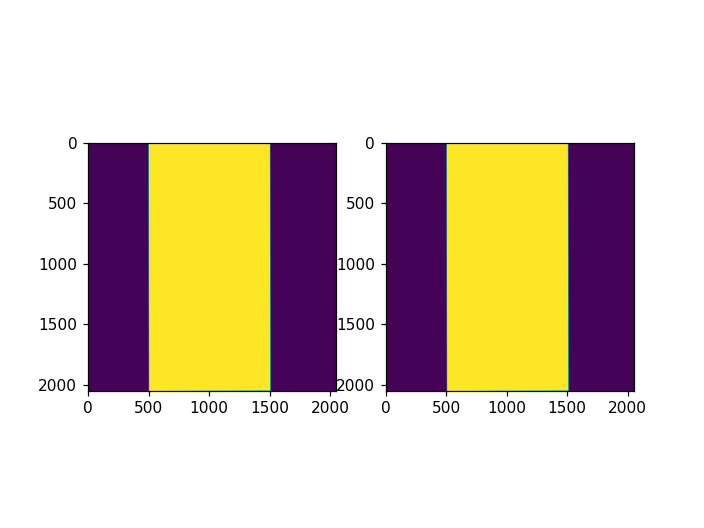

In [8]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(o_norm.data['sample']['data'][0])
ax[1] = plt.imshow(o_norm.data['sample']['data'][1])

In [9]:
o_center = UseCenter(image1=o_norm.data['sample']['data'][0],
                     image2=o_norm.data['sample']['data'][1])
o_direct = DirectMinimization(image1=o_norm.data['sample']['data'][0],
                              image2=o_norm.data['sample']['data'][1])
o_phase = PhaseCorrelation(image1=o_norm.data['sample']['data'][0],
                          image2=o_norm.data['sample']['data'][1])


In [10]:
print(f"center: {o_center.compute()}")
print(f"direct: {o_direct.compute()}")
print(f"phase correlation: {o_phase.compute()}")

center: nan
direct: 0.09999999999999928
phase correlation: 0.5064912259002092
